# Build Xception based Network

## 1. Starting journey with Xception network

In [1]:
# Import The Libraries
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import backend, layers, metrics

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# Setting random seeds to enable consistency while testing.
import random, os, cv2
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

def read_image(directory, index):
    path = os.path.join(directory, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (160, 160), interpolation = cv2.INTER_AREA)

    return image

### Train test split dataset

In [3]:
train_directory = "C:/face_recognition_data/celeb_mtcnn_crop_train"
test_directory = "C:/face_recognition_data/celeb_mtcnn_crop_val"

In [4]:
def split_dataset(train_directory, test_directory):
    # If split_as_cutpoint_number = True then split = split cutpoint number
    # If split_as_cutpoint_number = False then split = split ratio
    train_folders = os.listdir(train_directory)
    test_folders = os.listdir(test_directory)
    
    random.shuffle(train_folders)
    random.shuffle(test_folders)
    
    train_list, test_list = {}, {}
    
    # Creating Train-list
    for folder in train_folders:
        num_files = len(os.listdir(os.path.join(train_directory, folder)))
        train_list[folder] = num_files
    
    # Creating Test-list
    for folder in test_folders:
        num_files = len(os.listdir(os.path.join(test_directory, folder)))
        test_list[folder] = num_files  
    
    return train_list, test_list

# train_list, test_list = split_dataset(ROOT, split=0.86)
train_list, test_list = split_dataset(train_directory, test_directory)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

# train_list, test list contains the folder names along with the number of files in the folder.
print("\nTest List:", test_list)

Length of training list: 10000
Length of testing list : 133

Test List: {'Celeb_9588': 18, 'Celeb_1685': 18, 'Celeb_7977': 18, 'Celeb_7739': 18, 'Celeb_2071': 18, 'Celeb_1719': 18, 'Celeb_628': 18, 'Celeb_6203': 18, 'Celeb_1935': 18, 'Celeb_7272': 18, 'Celeb_4208': 18, 'Celeb_4008': 18, 'Celeb_9632': 18, 'Celeb_6133': 18, 'Celeb_5869': 18, 'Celeb_5857': 18, 'Celeb_570': 18, 'Celeb_5779': 18, 'Celeb_2515': 18, 'Celeb_2712': 18, 'Celeb_507': 18, 'Celeb_7027': 18, 'Celeb_5116': 18, 'Celeb_4079': 18, 'Celeb_2650': 18, 'Celeb_1702': 18, 'Celeb_4572': 18, 'Celeb_1677': 18, 'Celeb_883': 18, 'Celeb_1286': 18, 'Celeb_7221': 18, 'Celeb_1543': 18, 'Celeb_6010': 18, 'Celeb_7943': 18, 'Celeb_6788': 18, 'Celeb_5874': 18, 'Celeb_8300': 18, 'Celeb_9366': 18, 'Celeb_7089': 18, 'Celeb_4878': 18, 'Celeb_2490': 18, 'Celeb_2286': 18, 'Celeb_4851': 18, 'Celeb_9734': 18, 'Celeb_4201': 18, 'Celeb_2123': 18, 'Celeb_6780': 18, 'Celeb_6123': 18, 'Celeb_9468': 18, 'Celeb_6243': 18, 'Celeb_333': 18, 'Celeb_6244': 

### Creating Triplets

In [6]:
def create_triplets(directory, folder_list, max_files=21):     # max_files=60)
    triplets = []
    folders = list(folder_list.keys())
    
    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)
        
        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, files[i])
                positive = (folder, files[j])

                neg_folder = folder
                while neg_folder == folder:
                    neg_folder = random.choice(folders)
                neg_file = random.randint(0, folder_list[neg_folder]-1)
                
                neg_files = os.listdir(os.path.join(directory, neg_folder))
                negative = (neg_folder, neg_files[neg_file])

                triplets.append((anchor, positive, negative))
            
    random.shuffle(triplets)
    return triplets


In [7]:
train_triplet = create_triplets(train_directory, train_list)
test_triplet  = create_triplets(test_directory, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(5):
    print(train_triplet[i])

Number of training triplets: 1527004
Number of testing triplets : 20349

Examples of triplets:
(('Celeb_1052', 'Celeb_1052_16.jpg'), ('Celeb_1052', 'Celeb_1052_17.jpg'), ('Celeb_1434', 'Celeb_1434_9.jpg'))
(('Celeb_1294', 'Celeb_1294_12.jpg'), ('Celeb_1294', 'Celeb_1294_9.jpg'), ('Celeb_4583', 'Celeb_4583_25.jpg'))
(('Celeb_8485', 'Celeb_8485_12.jpg'), ('Celeb_8485', 'Celeb_8485_2.jpg'), ('Celeb_7243', 'Celeb_7243_13.jpg'))
(('Celeb_7877', 'Celeb_7877_0.jpg'), ('Celeb_7877', 'Celeb_7877_27.jpg'), ('Celeb_6302', 'Celeb_6302_3.jpg'))
(('Celeb_8582', 'Celeb_8582_1.jpg'), ('Celeb_8582', 'Celeb_8582_4.jpg'), ('Celeb_9485', 'Celeb_9485_0.jpg'))


In [8]:
train_triplet[0:2]

[(('Celeb_1052', 'Celeb_1052_16.jpg'),
  ('Celeb_1052', 'Celeb_1052_17.jpg'),
  ('Celeb_1434', 'Celeb_1434_9.jpg')),
 (('Celeb_1294', 'Celeb_1294_12.jpg'),
  ('Celeb_1294', 'Celeb_1294_9.jpg'),
  ('Celeb_4583', 'Celeb_4583_25.jpg'))]

### Batch generator to supply to Network

In [11]:
def get_batch(directory, triplet_list, batch_size=256, preprocess=True):
    n = len(triplet_list)
    batch_steps = n//batch_size; remainder = n % batch_size
    steps = (batch_steps + 1) if remainder!=0 else batch_steps
    
    for i in range(steps):
        anchor   = []
        positive = []
        negative = []
        
        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p, n = triplet_list[j]
            anchor.append(read_image(directory, a))
            positive.append(read_image(directory, p))
            negative.append(read_image(directory, n))
            j+=1
            
        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)
        
        if preprocess:
            anchor = preprocess_input(anchor)
            positive = preprocess_input(positive)
            negative = preprocess_input(negative)
        
        yield ([anchor, positive, negative])

### Plotting triplets

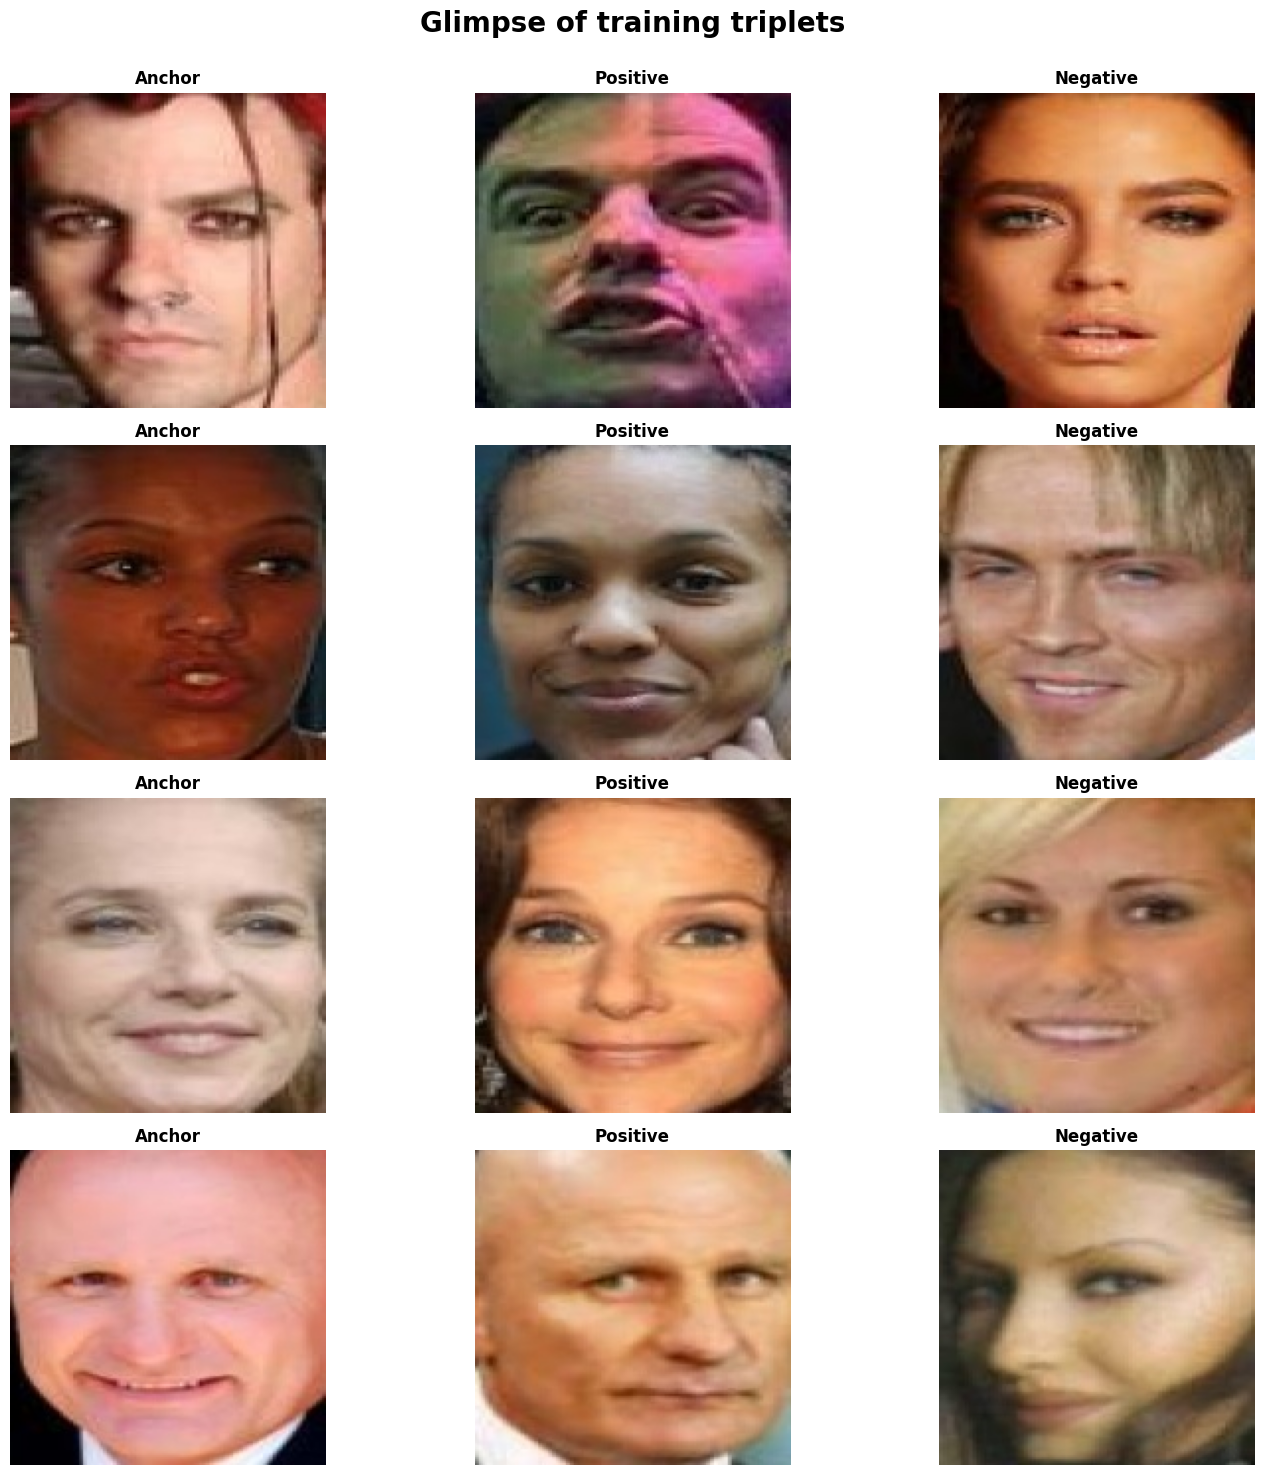

In [310]:
num_plots = 4

fig, axes = plt.subplots(num_plots, 3, figsize=(15, 15))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.suptitle("Glimpse of training triplets\n", fontsize=20, fontweight = "bold")

skip = 80; i = 0 # 10, 55, 90
for x in get_batch(train_directory, train_triplet, batch_size=num_plots, preprocess=False):
    if i>=skip:
        a,p,n = x
        for i in range(num_plots):
            axes[i, 0].imshow(a[i]); axes[i, 0].axis("off"); axes[i, 0].set_title("Anchor", fontsize=12, fontweight="bold")
            axes[i, 1].imshow(p[i]); axes[i, 1].axis("off"); axes[i, 1].set_title("Positive", fontsize=12, fontweight="bold")
            axes[i, 2].imshow(n[i]); axes[i, 2].axis("off"); axes[i, 2].set_title("Negative", fontsize=12, fontweight="bold")
            i+=1
        break
    i+=1

plt.axis("off")
plt.tight_layout()
# plt.savefig("models/celeb/Testing triplets.jpg", dpi = 50)

### 1.1 Initializing Xception Network

### Build Network

In [13]:
def block_1a(x, filters = 32, final_filters = 256, block_no = 1):
    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1
    
    if x.shape[-1] != final_filters:
        shape1 = x.shape[-1]; shape2 = final_filters
        raise ValueError('Inputs have incompatible shapes. 'f'Received shapes {shape1} and {shape2}. It should be: x.shape = final_filters')
    
    x = layers.Activation("relu", name="Block" + str(block_no) + "_add_act")(x)

    # Branch - 1
    branch1 = layers.Conv2D(
        filters, (1, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_conv1"
    )(x)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_conv1_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_conv1_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (3, 3), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv2"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv2_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv2_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (3, 3), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv3"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv3_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv3_act")(branch1)
     
    
    # Branch - 2
    branch2 = layers.Conv2D(filters, (1, 1), use_bias=False, name="Block" + str(block_no) + "_branch_2_conv1")(x)
    branch2 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_2_conv1_bn")(branch2)
    branch2 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_2_conv1_act")(branch2)
    # -------------
    branch2 = layers.SeparableConv2D(
        filters, (3, 3), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_2_sepconv2"
    )(branch2)
    branch2 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_2_sepconv2_bn")(branch2)
    branch2 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_2_sepconv2_act")(branch2)

    # Branch - 3
    branch3 = layers.Conv2D(filters, (1, 1), use_bias=False, name="Block" + str(block_no) + "_branch_3_conv1")(x)
    branch3 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_3_conv1_bn")(branch3)
    branch3 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_3_conv1_act")(branch3)
    
    
    # Concate Branch - 1, Branch - 2 and Branch - 3
    concate = layers.concatenate([branch1, branch2, branch3])
    concate = layers.Conv2D(
        final_filters, (1, 1), padding="same", use_bias=True, name="Block" + str(block_no) + "_concate_sepconv1"
    )(concate)
    
    # Branch - 3 (Residual)
    residual_branch = x
    
    # Add Concate and Residual 
    out = layers.add([concate, residual_branch])
    
    return out


def block_1b(x, filters = 128, branch1_up_filters = 256, branch2_up_filters = 384, block_no = 1):
    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1
    
    x = layers.Activation("relu", name="Block" + str(block_no) + "_add_act")(x)

    # Branch - 1
    branch1 = layers.Conv2D(
        filters, (1, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_conv1"
    )(x)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_conv1_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_conv1_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (3, 3), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv2"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv2_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv2_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        branch1_up_filters, (3, 3), strides = (2, 2), use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv3"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv3_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv3_act")(branch1)
     
    
    # Branch - 2
    branch2 = layers.SeparableConv2D(
        branch2_up_filters, (3, 3), strides = (2, 2), use_bias=False, name="Block" + str(block_no) + "_branch_2_sepconv1"
    )(x)
    branch2 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_2_sepconv1_bn")(branch2)
    branch2 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_2_sepconv1_act")(branch2)
    
    # Branch - 3 (Residual)
    residual_branch = layers.MaxPooling2D((3, 3), strides=(2, 2),
                                          name="Block" + str(block_no) + "_branch_3_block2_pool")(x)
    
    # Concate Branch - 1, Branch - 2 and Branch - 3
    out = layers.concatenate([branch1, branch2, residual_branch])
    
    return out

# After Brown Concatenate
def block_1c(x, filters = 128, final_filters = 896, block_no = 1):
    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1
    
    if x.shape[-1] != final_filters:
        shape1 = x.shape[-1]; shape2 = final_filters
        raise ValueError('Inputs have incompatible shapes. 'f'Received shapes {shape1} and {shape2}. It should be: x.shape = final_filters')
    
    # Branch - 1
    branch1 = layers.Conv2D(
        filters, (1, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_conv1"
    )(x)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_conv1_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_conv1_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (1, 7), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv2"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv2_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv2_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (7, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv3"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv3_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv3_act")(branch1)
     
    
    # Branch - 2
    branch2 = layers.Conv2D(filters, (1, 1), use_bias=False, name="Block" + str(block_no) + "_branch_2_conv1")(x)
    branch2 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_2_conv1_bn")(branch2)
    branch2 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_2_conv1_act")(branch2)
    
    
    # Concate Branch - 1, Branch - 2 and Branch - 3
    concate = layers.concatenate([branch1, branch2])
    concate = layers.Conv2D(
        final_filters, (1, 1), padding="same", use_bias=True, name="Block" + str(block_no) + "_concate_conv1"
    )(concate)
    
    # Branch - 3 (Residual)
    residual_branch = x
    
    # Add Concate and Residual 
    out = layers.add([concate, residual_branch])
    
    return out

def block_2c(x, filters = 128, final_filters = 896, block_no = 1):
    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1
    
    if x.shape[-1] != final_filters:
        shape1 = x.shape[-1]; shape2 = final_filters
        raise ValueError('Inputs have incompatible shapes. 'f'Received shapes {shape1} and {shape2}. It should be: x.shape = final_filters')
    
    x = layers.Activation("relu", name="Block" + str(block_no) + "_add_act")(x)
    
    # Branch - 1
    branch1 = layers.Conv2D(
        filters, (1, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_conv1"
    )(x)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_conv1_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_conv1_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (1, 7), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv2"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv2_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv2_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (7, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv3"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv3_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv3_act")(branch1)
     
    
    # Branch - 2
    branch2 = layers.Conv2D(filters, (1, 1), use_bias=False, name="Block" + str(block_no) + "_branch_2_conv1")(x)
    branch2 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_2_conv1_bn")(branch2)
    branch2 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_2_conv1_act")(branch2)
    
    
    # Concate Branch - 1, Branch - 2 and Branch - 3
    concate = layers.concatenate([branch1, branch2])
    concate = layers.Conv2D(
        final_filters, (1, 1), padding="same", use_bias=True, name="Block" + str(block_no) + "_concate_conv1"
    )(concate)
    
    # Branch - 3 (Residual)
    residual_branch = x
    
    # Add Concate and Residual 
    out = layers.add([concate, residual_branch])
    
    return out


def block_1d(x, filters = 256, branch2_up_filters = 384, block_no = 1):
    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1

    x = layers.Activation("relu", name="Block" + str(block_no) + "_add_act")(x)

    # Branch - 1
    branch1 = layers.Conv2D(
        filters, (1, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_conv1"
    )(x)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_conv1_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_conv1_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (3, 3), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv2"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv2_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv2_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (3, 3), strides = (2, 2), use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv3"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv3_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv3_act")(branch1)
     
    
    # Branch - 2
    branch2 = layers.Conv2D(filters, (1, 1), use_bias=False, name="Block" + str(block_no) + "_branch_2_conv1")(x)
    branch2 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_2_conv1_bn")(branch2)
    branch2 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_2_conv1_act")(branch2)
    # -------------
    branch2 = layers.SeparableConv2D(
        branch2_up_filters, (3, 3), strides = (2, 2), use_bias=False, name="Block" + str(block_no) + "_branch_2_sepconv2"
    )(branch2)
    branch2 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_2_sepconv2_bn")(branch2)
    branch2 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_2_sepconv2_act")(branch2)
    
        
    # Branch - 3
    branch3 = layers.Conv2D(filters, (1, 1), use_bias=False, name="Block" + str(block_no) + "_branch_3_conv1")(x)
    branch3 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_3_conv1_bn")(branch3)
    branch3 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_3_conv1_act")(branch3)
    # -------------
    branch3 = layers.SeparableConv2D(
        filters, (3, 3), strides = (2, 2), use_bias=False, name="Block" + str(block_no) + "_branch_3_sepconv2"
    )(branch3)
    branch3 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_3_sepconv2_bn")(branch3)
    branch3 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_3_sepconv2_act")(branch3)
    
    # Branch - 4 (Residual)
    residual_branch = layers.MaxPooling2D((3, 3), strides=(2, 2),
                                          name="Block" + str(block_no) + "_branch_3_block2_pool")(x)
    
    # Concate Branch - 1, Branch - 2, Branch - 3 and Branch - 3
    out = layers.concatenate([branch1, branch2, branch3, residual_branch])
    
    return out

def block_1e(x, filters = 192, final_filters = 1792, block_no = 1):
    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1
    
    if x.shape[-1] != final_filters:
        shape1 = x.shape[-1]; shape2 = final_filters
        raise ValueError('Inputs have incompatible shapes. 'f'Received shapes {shape1} and {shape2}. It should be: x.shape = final_filters')
        
    # Branch - 1
    branch1 = layers.Conv2D(
        filters, (1, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_conv1"
    )(x)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_conv1_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_conv1_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (1, 3), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv2"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv2_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv2_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (3, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv3"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv3_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv3_act")(branch1)
     
    
    # Branch - 2
    branch2 = layers.Conv2D(filters, (1, 1), use_bias=False, name="Block" + str(block_no) + "_branch_2_conv1")(x)
    branch2 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_2_conv1_bn")(branch2)
    branch2 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_2_conv1_act")(branch2)
    
    
    # Concate Branch - 1, Branch - 2 and Branch - 3
    concate = layers.concatenate([branch1, branch2])
    concate = layers.Conv2D(
        final_filters, (1, 1), padding="same", use_bias=True, name="Block" + str(block_no) + "_concate_conv1"
    )(concate)
    
    # Branch - 3 (Residual)
    residual_branch = x
    
    # Add Concate and Residual 
    out = layers.add([concate, residual_branch])
    
    return out

def block_2e(x, filters = 192, final_filters = 1792, block_no = 1):
    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1
    
    if x.shape[-1] != final_filters:
        shape1 = x.shape[-1]; shape2 = final_filters
        raise ValueError('Inputs have incompatible shapes. 'f'Received shapes {shape1} and {shape2}. It should be: x.shape = final_filters')
    
    x = layers.Activation("relu", name="Block" + str(block_no) + "_add_act")(x)
    
    # Branch - 1
    branch1 = layers.Conv2D(
        filters, (1, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_conv1"
    )(x)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_conv1_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_conv1_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (1, 3), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv2"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv2_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv2_act")(branch1)
    # -------------
    branch1 = layers.SeparableConv2D(
        filters, (3, 1), padding="same", use_bias=False, name="Block" + str(block_no) + "_branch_1_sepconv3"
    )(branch1)
    branch1 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_1_sepconv3_bn")(branch1)
    branch1 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_1_sepconv3_act")(branch1)
     
    
    # Branch - 2
    branch2 = layers.Conv2D(filters, (1, 1), use_bias=False, name="Block" + str(block_no) + "_branch_2_conv1")(x)
    branch2 = layers.BatchNormalization(axis=channel_axis, name="Block" + str(block_no) + "_branch_2_conv1_bn")(branch2)
    branch2 = layers.Activation("relu", name="Block" + str(block_no) + "_branch_2_conv1_act")(branch2)
    
    
    # Concate Branch - 1, Branch - 2 and Branch - 3
    concate = layers.concatenate([branch1, branch2])
    concate = layers.Conv2D(
        final_filters, (1, 1), padding="same", use_bias=True, name="Block" + str(block_no) + "_concate_conv1"
    )(concate)
    
    # Branch - 3 (Residual)
    residual_branch = x
    
    # Add Concate and Residual 
    out = layers.add([concate, residual_branch])
    
    return out


In [14]:
import tensorflow.compat.v2 as tf

from keras import backend
from keras.applications import imagenet_utils
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils

# isort: off
from tensorflow.python.util.tf_export import keras_export

TF_WEIGHTS_PATH = (
    "https://storage.googleapis.com/tensorflow/keras-applications/"
    "xception/xception_weights_tf_dim_ordering_tf_kernels.h5"
)
TF_WEIGHTS_PATH_NO_TOP = (
    "https://storage.googleapis.com/tensorflow/keras-applications/"
    "xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5"
)

layers = VersionAwareLayers()


def sinception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """Instantiates the Xception architecture.

    Reference:
    - [Xception: Deep Learning with Depthwise Separable Convolutions](
        https://arxiv.org/abs/1610.02357) (CVPR 2017)

    For image classification use cases, see
    [this page for detailed examples](
      https://keras.io/api/applications/#usage-examples-for-image-classification-models).

    For transfer learning use cases, make sure to read the
    [guide to transfer learning & fine-tuning](
      https://keras.io/guides/transfer_learning/).

    The default input image size for this model is 299x299.

    Note: each Keras Application expects a specific kind of input preprocessing.
    For Xception, call `tf.keras.applications.xception.preprocess_input` on your
    inputs before passing them to the model.
    `xception.preprocess_input` will scale input pixels between -1 and 1.

    Args:
      include_top: whether to include the fully-connected
        layer at the top of the network.
      weights: one of `None` (random initialization),
        'imagenet' (pre-training on ImageNet),
        or the path to the weights file to be loaded.
      input_tensor: optional Keras tensor
        (i.e. output of `layers.Input()`)
        to use as image input for the model.
      input_shape: optional shape tuple, only to be specified
        if `include_top` is False (otherwise the input shape
        has to be `(299, 299, 3)`.
        It should have exactly 3 inputs channels,
        and width and height should be no smaller than 71.
        E.g. `(150, 150, 3)` would be one valid value.
      pooling: Optional pooling mode for feature extraction
        when `include_top` is `False`.
        - `None` means that the output of the model will be
            the 4D tensor output of the
            last convolutional block.
        - `avg` means that global average pooling
            will be applied to the output of the
            last convolutional block, and thus
            the output of the model will be a 2D tensor.
        - `max` means that global max pooling will
            be applied.
      classes: optional number of classes to classify images
        into, only to be specified if `include_top` is True,
        and if no `weights` argument is specified.
      classifier_activation: A `str` or callable. The activation function to use
        on the "top" layer. Ignored unless `include_top=True`. Set
        `classifier_activation=None` to return the logits of the "top" layer.
        When loading pretrained weights, `classifier_activation` can only
        be `None` or `"softmax"`.

    Returns:
      A `keras.Model` instance.
    """
    if not (weights in {"imagenet", None} or tf.io.gfile.exists(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights` as `"imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=299,
        min_size=71,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape, name = "input_1")
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    channel_axis = 1 if backend.image_data_format() == "channels_first" else -1

    x = layers.Conv2D(
        32, (3, 3), strides=(2, 2), padding = "valid", use_bias=False, name="Conv1"
    )(img_input)
    x = layers.BatchNormalization(axis=channel_axis, name="Conv1_bn")(x)
    x = layers.Activation("relu", name="Conv1_act")(x)
    
    x = layers.Conv2D(32, (3, 3), padding = "valid", use_bias=False, name="Conv2")(x)
    x = layers.BatchNormalization(axis=channel_axis, name="Conv2_bn")(x)
    x = layers.Activation("relu", name="Conv2_act")(x)
    
    x = layers.Conv2D(64, (3, 3), padding = "same", use_bias=False, name="Conv3")(x)
    x = layers.BatchNormalization(axis=channel_axis, name="Conv3_bn")(x)
    x = layers.Activation("relu", name="Conv3_act")(x)
    
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), name="MaxPool")(x)
    
    x = layers.Conv2D(80, (1, 1), padding = "same", use_bias=False, name="Conv4")(x)
    x = layers.BatchNormalization(axis=channel_axis, name="Conv4_bn")(x)
    x = layers.Activation("relu", name="Conv4_act")(x)
    
    x = layers.Conv2D(192, (3, 3), padding = "valid", use_bias=False, name="Conv5")(x)
    x = layers.BatchNormalization(axis=channel_axis, name="Conv5_bn")(x)
    x = layers.Activation("relu", name="Conv5_act")(x)
    
    x = layers.Conv2D(256, (3, 3), strides = (2, 2), padding = "valid", use_bias=False, name="Conv6")(x)
    x = layers.BatchNormalization(axis=channel_axis, name="Conv6_bn")(x)
    x = layers.Activation("relu", name="Conv6_act")(x)
    
#-------------------------------------------------------------------------

    for i in range(5): #5
        x = block_1a(x, filters = 32, final_filters = 256, block_no = str(i + 3)+"_1a")
    
    x = block_1b(x, filters = 192, branch1_up_filters = 256, branch2_up_filters = 384, block_no = str(i + 4)+"_1b")
    x = block_1c(x, filters = 128, final_filters = 256+256+384, block_no = str(i + 5)+"_1c")

    for j in range(9): #9
        x = block_2c(x, filters = 128, final_filters = 256+256+384, block_no = str(j + i + 6)+"_2c")
    
    x = block_1d(x, filters = 256, branch2_up_filters = 384, block_no = str(j + i + 7)+"_1d")
    x = block_1e(x, filters = 192, final_filters = 1792, block_no = str(j + i + 8)+"_1e")

    for k in range(5): #5
        x = block_2e(x, filters = 192, final_filters = 1792, block_no = str(k + j + i + 9)+"_2e")
        
#-------------------------------------------------------------------------

    
    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        x = layers.Dense(classes, activation = classifier_activation)(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = training.Model(inputs, x, name="sinception")

    return model

base = sinception(
            input_shape = (160, 160, 3),
            weights = None, # Default weights.
            include_top = False,
            pooling='avg'
        )
base.summary()


Model: "sinception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 79, 79, 32)   864         ['input_1[0][0]']                
                                                                                                  
 Conv1_bn (BatchNormalization)  (None, 79, 79, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_act (Activation)         (None, 79, 79, 32)   0           ['Conv1_bn[0][0]']      

### Build Encoder

In [15]:
def get_encoder(input_shape, backbone):
    print("[INFO] Building backbone based on: " + backbone)

    if backbone == "xception":
        from tensorflow.keras.applications.xception import Xception
        base_net = Xception(
            input_shape = input_shape,
            weights = "imagenet", # Default weights.
            include_top = False,
            pooling='avg'
        )
#         base_net.load_weights("models_new/new_experiment/xception/model")
    
    if backbone == "sinception":        
        base_net = sinception(
            input_shape = input_shape,
            weights = None, # Default weights.
            include_top = False,
            pooling='avg'
        )  
#         base_net.load_weights("models/celeb/classification_model_initialize/model")
    
    from tensorflow.keras import layers

    encode_model = Sequential([
        base_net,
        layers.Dense(1024, activation = "relu"),
        layers.BatchNormalization(),
        layers.Dense(512, activation = "relu"),
        layers.BatchNormalization(),
        layers.Dense(256, activation = "relu"),
        layers.BatchNormalization(),
        layers.Dense(128),
        layers.BatchNormalization(),

        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name = "L2_Normalize")
    ], name = "Encode_model")
    
    print("[INFO] Network successfully built based on: " + backbone)

    return encode_model

In [16]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

    
def get_siamese_network(input_shape = (160, 160, 3)):
    encoder = get_encoder(input_shape = (160,160,3), backbone = "sinception")

    from tensorflow.keras import layers
    # Input Layers for the images
    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")
    
    ## Generate the encodings (feature vectors) for the images
    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)
    
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    distances = DistanceLayer()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )
    
    # Creating the Model 
    # Use training.Model when using Custom Xception Network
    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

siamese_network = get_siamese_network()
siamese_network.summary()

[INFO] Building backbone based on: sinception
[INFO] Network successfully built based on: sinception
Model: "Siamese_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Anchor_Input (InputLayer)      [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Positive_Input (InputLayer)    [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Negative_Input (InputLayer)    [(None, 160, 160, 3  0           []               

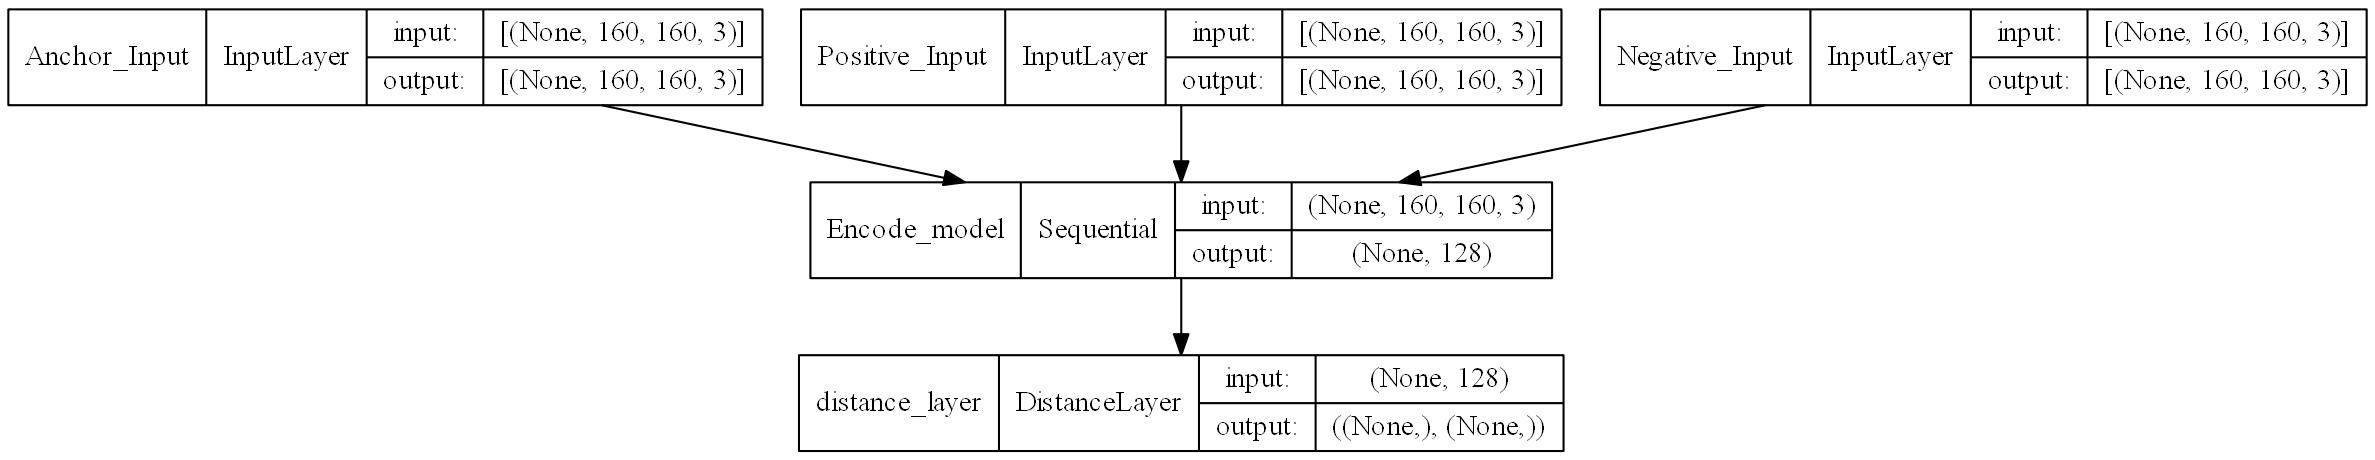

In [17]:
# plot_model(siamese_network, show_shapes=True, show_layer_names=True, to_file = "models/plots/custom_architecture_triplet_loss.jpg", dpi = 400)
plot_model(siamese_network, show_shapes=True, show_layer_names=True, dpi = 150, to_file = "models/celeb/siamese_model.jpg")

In [18]:
class SiameseModel(Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()
        
        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")
        self.ap_dist_tracker = metrics.Mean(name="ap_dist")
        self.an_dist_tracker = metrics.Mean(name="an_dist")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape get the gradients when we compute loss, and uses them to update the weights
        with tf.GradientTape() as tape:
            loss, ap_distance, an_distance = self._compute_loss(data)
            
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))
        
        self.loss_tracker.update_state(loss)
        self.ap_dist_tracker.update_state(ap_distance)
        self.an_dist_tracker.update_state(an_distance)
        return {"loss": self.loss_tracker.result(), "ap_dist": self.ap_dist_tracker.result(), "an_dist": self.an_dist_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)
        
        self.loss_tracker.update_state(loss)
        self.ap_dist_tracker.update_state(ap_distance)
        self.an_dist_tracker.update_state(an_distance)

        return {"loss": self.loss_tracker.result(), "ap_dist": self.ap_dist_tracker.result(), "an_dist": self.an_dist_tracker.result()}

    def _compute_loss(self, data):
        # Get the two distances from the network, then compute the triplet loss
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
         # ap distance<threshold or andistance>threshold  <-- For final model (Here not needed anything)
        return loss, ap_distance, an_distance

    @property
    def metrics(self):
        # We need to list our metrics so the reset_states() can be called automatically.
        return [self.loss_tracker, self.ap_dist_tracker, self.an_dist_tracker]

In [21]:
siamese_model = SiameseModel(siamese_network)
optimizer = Adam(learning_rate=5e-5, epsilon=1e-03)
siamese_model.compile(optimizer=optimizer)
siamese_model.optimizer.learning_rate.numpy()

5e-05

In [315]:
img1 = cv2.imread("lfw_mtcnn_crop/Aaron_Peirsol/Aaron_Peirsol_0001.jpg")
img1 = np.expand_dims(img1, axis=0)/127.5-1
img2 = cv2.imread("lfw_mtcnn_crop/Aaron_Peirsol/Aaron_Peirsol_0004.jpg")
img2 = np.expand_dims(img2, axis=0)/127.5-1

img3 = cv2.imread("lfw_mtcnn_crop/Abdullah/Abdullah_0001.jpg")
img3 = np.expand_dims(img3, axis=0)/127.5-1

img5 = cv2.imread("lfw_mtcnn_crop/Bill_Gates/Bill_Gates_0001.jpg")
img5 = np.expand_dims(img5, axis=0)/127.5-1
img6 = cv2.imread("lfw_mtcnn_crop/Bill_Gates/Bill_Gates_0005.jpg")
img6 = np.expand_dims(img6, axis=0)/127.5-1

d = siamese_network.predict([a, p, n])
print("Anchor-positive distances:", d[0])
print("Anchor-negative distances:", d[1])

Anchor-positive distances: [0.14932494 0.31575984 0.62794137 0.12297224]
Anchor-negative distances: [1.0734738 1.396791  1.1209695 1.3217988]


In [52]:
def test_acc_on_triplets(directory, batch_size = 8, threshold = 1):
    pos_scores, neg_scores = [], []
    
    for data in get_batch(directory, test_triplet, batch_size=batch_size, preprocess=True):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
    
    accuracy_test = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    pos_list = np.where(np.array(pos_scores)<=threshold, 0, 1)
    neg_list = np.where(np.array(neg_scores)<=threshold, 0, 1)    
    
    print(f"Accuracy on test = {accuracy_test:.5f}\n")
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    accuracy = accuracy_score(true, pred)
    print("-"*100)
    print(f"Accuracy of model: {accuracy} [Under threshold = {threshold}]")
    
    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)


def test_acc_on_triplets_batch_details(directory, batch_size = 8, threshold = 1):
    pos_scores, neg_scores = [], []
    pbar = tqdm(desc="Validating", total=int(len(test_triplet)/batch_size)+1)
    for data in get_batch(directory, test_triplet, batch_size=batch_size, preprocess=True):
        prediction = siamese_model.predict(data)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])
        pbar.update(1)
    pbar.close()
    
    accuracy_test = np.sum(np.array(pos_scores) < np.array(neg_scores)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)
    
    pos_list = np.where(np.array(pos_scores)<=threshold, 0, 1)
    neg_list = np.where(np.array(neg_scores)<=threshold, 0, 1)    
    
    print(f"Accuracy on test = {accuracy_test:.5f}\n")
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    accuracy = accuracy_score(true, pred)
    print("-"*100)
    print(f"Accuracy of model: {accuracy} [Under threshold = {threshold}]")
    
    return (accuracy, pos_scores, neg_scores, ap_mean, an_mean, ap_stds, an_stds)

In [25]:
i = 1 # Experiment - 1

import pickle

def write_summary(epoch, epochs, batch_loss, all_batch_loss, aps, ans, tr_loss, test_met, max_acc, max_acc_epoch, progress, tim):
    data = {"running_epoch": epoch, "total_epochs": epochs, "batch_loss": batch_loss, "all_batch_loss": all_batch_loss, 
            "ap": ap_mean, "an": an_mean, "train_loss": tr_loss, "test_metrics": test_met, "max_accuracy": max_acc, "max_accuracy_epoch": max_acc_epoch, 
            "progress": progress, "time": tim}
    
    with open("models/celeb/experiment_" + str(i) + "_summary.p", "wb") as file:
        pickle.dump(data, file, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
i = 1
import time, json
from tqdm import tqdm

import datetime
now = datetime.datetime.now()
print("Starting at:",now)

save_all = False
epochs = 10
batch_size = 16

max_acc = 0
max_acc_epoch = None

train_loss = []
test_metrics = []

epoch = 0; all_loss = []; all_ap = []; all_an = []


while epoch < epochs:
    
    with open("models/celeb/config.json", "r") as file:
        cfg = json.load(file)
    if cfg["set_lr"]:
        tf.keras.backend.set_value(siamese_model.optimizer.learning_rate, cfg["lr"])  # set new learning_rate
    
    epoch += 1
    n = len(train_triplet)
    print("\nStarting Epoch: " + str(epoch) + ", Learning Rate: " + str(siamese_model.optimizer.learning_rate.numpy()))
    pbar = tqdm(desc ="Epoch " + str(epoch) + "/" + str(epochs) + ": [Loss = NA]", total = int(n/batch_size)+1)
    t = time.time()

    # Training the model on train data
    epoch_loss = []; n_batch = 0; aps = []; ans = []

    for data in get_batch(train_directory, train_triplet, batch_size=batch_size, preprocess=True):
        loss, ap, an = siamese_model.train_on_batch(data)
        epoch_loss.append(loss); batch_loss = list(reversed(epoch_loss))[0:100]
        aps.append(ap); ap_mean = sum(aps)/len(aps)
        ans.append(an); an_mean = sum(ans)/len(ans)
        batch_loss = sum(batch_loss)/len(batch_loss)
        all_batch_loss = sum(epoch_loss)/len(epoch_loss)
        all_loss.append(loss); all_ap.append(ap); all_an.append(an)
        

        pbar.set_description("Epoch " + str(epoch) + "/" + str(epochs) + 
                             ": [Loss = "+ str(round(batch_loss, 4)) +" (last 100), " + str(round(all_batch_loss, 4)) + " (all), "
                             "lr = " + str(siamese_model.optimizer.learning_rate.numpy()) + "]")
        pbar.update(1)
        
        n_batch += 1; tim = 0
        if n_batch % 50 == 0:
            
            total = int(n/batch_size)+1; progress = (len(epoch_loss)/total)*100; tim = time.time()-t
            write_summary(epoch, epochs, batch_loss, all_batch_loss, ap_mean, an_mean, train_loss, test_metrics, max_acc, max_acc_epoch, progress, tim)

            with open("models/celeb/config.json", "r") as file:
                cfg = json.load(file)
            if cfg["set_lr"]:
                lr_flag = False
                tf.keras.backend.set_value(siamese_model.optimizer.learning_rate, cfg["lr"])  # set new learning_rate
            if cfg["save_model"]:
                model_save_path = "models/celeb/experiment_" + str(i) + "_epochs/subepoch_" + str(epoch)
                print("[On the sfly, model saved at:", model_save_path, "]")
                siamese_model.save_weights(model_save_path)
                
            if not cfg["set_lr"]:
                lr_flag = True 
            if cfg["force_stop"]:
                break
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(epoch_loss)
    pbar.close()
    
    print(f"EPOCH: {epoch}/{epochs}\t (Epoch done in {int(time.time()-t)} sec)")
    print(f"Loss on train    = {epoch_loss:.5f}")
    
    progress = 100
    write_summary(epoch, epochs, batch_loss, all_batch_loss, ap_mean, an_mean, train_loss, test_metrics, max_acc, max_acc_epoch, progress, tim)
    
    dic = {"all_loss": all_loss, "all_ap": all_ap, "all_an": all_an}
    with open("models/celeb/experiment_" + str(i) + "_loss_ap_an/cumulative_epoch_" + str(epoch) + "_loss_ap_an.p", "wb") as file:
        pickle.dump(dic, file, protocol=pickle.HIGHEST_PROTOCOL)
 
    # Testing the model on test data
    metric = test_acc_on_triplets(test_directory, batch_size=8)
    test_metrics.append(metric)
    accuracy = metric[0]; tim = time.time()-t
    
    print("[Measures]: AP Mean =", metric[1], ", AN Mean =", metric[2], ", AP S.D. =", metric[3], ", AN S.D. =", metric[4])
    print("-"*100)
    
    # Saving the model weights
    if save_all or accuracy>=max_acc:
        model_save_path = "models/celeb/experiment_" + str(i) + "_epochs/epoch_" + str(epoch)
        print("Accuracy improved from", max_acc, "to", accuracy," [ Model saved at:", model_save_path, "]")
        siamese_model.save_weights(model_save_path)
        max_acc = accuracy; max_acc_epoch = epoch
        
    if save_all or accuracy<max_acc:
        print("Accuracy did not improve from", max_acc, "[Model save skipped]")
       
    write_summary(epoch, epochs, batch_loss, all_batch_loss, aps, ans, train_loss, test_metrics, max_acc, max_acc_epoch, progress, tim)
       
    with open("models/celeb/config.json", "r") as file:
        cfg = json.load(file)

    if cfg["stop_epoch"] or cfg["force_stop"]:
        break
        
dic = {"all_loss": all_loss, "all_ap": all_ap, "all_an": all_an}
with open("models/celeb/experiment_" + str(i) + "_loss_ap_an.p", "wb") as file:
    pickle.dump(dic, file, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving the model after all epochs run
siamese_model.save_weights("models/celeb/experiment_" + str(i) + "_final/siamese")

# 29.05.2023 >> 1:34 P.M. Start the notebook
# 29.05.2023 >> 1:38 P.M. GPU Response
# 12 hours 30 mins
# 30.05.2023 >> 4:16 P.M. Epoch 1 Train complete
# 30.05.2023 >> 4:27 P.M. Manual Epoch 1 Val start
# 30.05.2023 >> 4:27 P.M. Manual Epoch 1 Val complete

Starting at: 2023-06-01 03:32:15.807628

Starting Epoch: 1, Learning Rate: 5e-05


Epoch 1/10: [Loss = 0.169 (last 100), 0.3041 (all), lr = 5e-06]:  96%|███████▋| 91600/95438 [11:59:24<30:12,  2.12it/s]

[On the sfly, model saved at: models/celeb/experiment_1_epochs/subepoch_1 ]


Epoch 1/10: [Loss = 0.1641 (last 100), 0.3007 (all), lr = 1e-06]:  99%|██████▉| 94050/95438 [12:18:44<10:51,  2.13it/s]

[On the sfly, model saved at: models/celeb/experiment_1_epochs/subepoch_1 ]


Epoch 1/10: [Loss = 0.1564 (last 100), 0.2988 (all), lr = 1e-06]: 100%|███████| 95438/95438 [12:30:01<00:00,  2.12it/s]


EPOCH: 1/10	 (Epoch done in 45001 sec)
Loss on train    = 0.29881
Accuracy on test = 0.93715

----------------------------------------------------------------------------------------------------
Accuracy of model: 0.8508526217504546 [Under threshold = 1]
[Measures]: AP Mean = 0.6525457 , AN Mean = 1.9914366 , AP S.D. = 0.507762 , AN S.D. = 0.5986715
----------------------------------------------------------------------------------------------------
Accuracy improved from 0 to 0.8508526217504546  [ Model saved at: models/celeb/experiment_1_epochs/epoch_1 ]


## Evaluate our model

In [53]:
accuracy, ap_test, an_test, ap_mean, an_mean, ap_stds, an_stds = test_acc_on_triplets_batch_details(test_directory, batch_size=4)

Validating: 100%|██████████████████████████████████████████████████████████████████| 5088/5088 [13:03<00:00,  6.49it/s]

Accuracy on test = 0.93715

----------------------------------------------------------------------------------------------------
Accuracy of model: 0.8508526217504546 [Under threshold = 1]


## Dump all data for future references

In [253]:
import pickle    
i = 1

# test_dic = {"test_ap": ap_test, "test_an": an_test}

# with open("models/celeb/experiment_" + str(i) + "_test_ap_an.p", "wb") as file:
#     pickle.dump(dic, file, protocol=pickle.HIGHEST_PROTOCOL)

with open("models/celeb/experiment_" + str(i) + "_test_ap_an.p", "rb") as file:
    test_data = pickle.load(file)

with open("models/celeb/experiment_" + str(i) + "_loss_ap_an.p", "rb") as file:
    all_data = pickle.load(file)
    
all_loss = all_data["all_loss"]; ap_train = all_data["all_ap"]; an_train = all_data["all_an"]

In [ ]:
all_data.keys()

In [254]:
m = len(ap_train)
n_points = 5000; s = int(m/n_points)

s = 500; n_points = int(m/s) # If s is fixed

ap = []; an = []; loss = []
for i in range(n_points+1):
#     print(i)
    ap.append(np.mean(ap_train[(i*s):((i+1)*s)]))
    an.append(np.mean(an_train[(i*s):((i+1)*s)]))
    loss.append(np.mean(all_loss[(i*s):((i+1)*s)]))
len(ap), len(an), len(loss), s, n_points


(191, 191, 191, 500, 190)

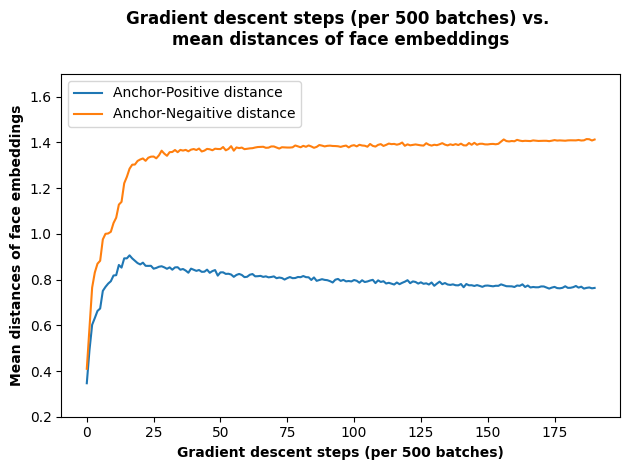

In [255]:
import matplotlib.pyplot as plt
import numpy as np

ap_points = np.array(ap); ap_points = np.sqrt(ap)
an_points = np.array(an); an_points = np.sqrt(an)

plt.plot(ap_points, linestyle = 'solid', label = "Anchor-Positive distance")
plt.plot(an_points, linestyle = 'solid', label = "Anchor-Negaitive distance")
plt.xlabel("Gradient descent steps (per 500 batches)", fontweight = "bold")
plt.ylabel("Mean distances of face embeddings", fontweight = "bold")
plt.ylim([0.2, 1.7])
plt.title("Gradient descent steps (per 500 batches) vs. \nmean distances of face embeddings\n", fontweight = "bold")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.savefig("models/celeb/Gradient descent ap an.jpg", dpi = 200)

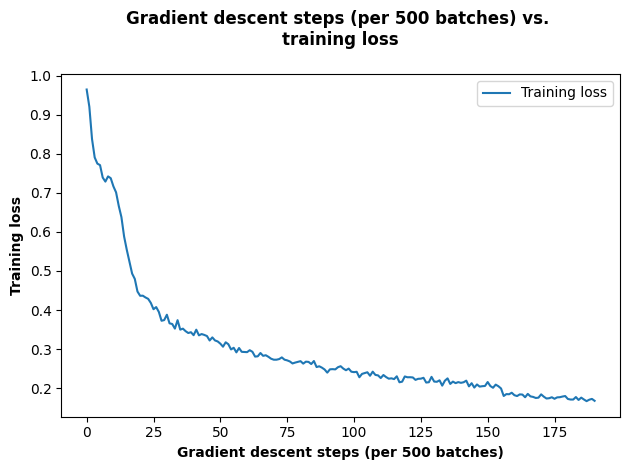

In [256]:
loss_points = np.array(loss)
plt.plot(loss_points, linestyle = 'solid', label = "Training loss")
plt.xlabel("Gradient descent steps (per 500 batches)", fontweight = "bold")
plt.ylabel("Training loss", fontweight = "bold")
plt.title("Gradient descent steps (per 500 batches) vs. \ntraining loss\n", fontweight = "bold")
plt.legend(loc = "upper right")
plt.tight_layout()
plt.savefig("models/celeb/Gradient descent training loss.jpg", dpi = 200)

### Extract encoder i.e. sister network

In [36]:
# For Customized Xception Network only

def extract_encoder(model):
    inputs = model.layers[3].layers[0].inputs
    out = model.layers[3].layers[0](inputs)
    
    x = layers.Dense(1024, activation = "relu")(out)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation = "relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(256, activation = "relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128)(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name = "L2_Normalize")(x)

    encoder = Model(inputs, outputs, name = "Encode_model")
    
    i = 2
    for e_layer in model.layers[3].layers[1:]:
        weight = e_layer.get_weights()
        encoder.layers[i].set_weights(weight)
        i +=1
        
    return encoder

encoder = extract_encoder(siamese_network)

encoder.save_weights("models/celeb/encoder_weights/face_model")
encoder.save("models/celeb/encoder/face_model.h5")

### Confusion matrix

In [ ]:
def classify_images(face_list1, face_list2, threshold=1):
    # Getting the encodings for the passed faces
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
#     distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    distance = np.linalg.norm(tensor1-tensor2), axis = -1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction


Accuracy of model: 0.8508526217504546



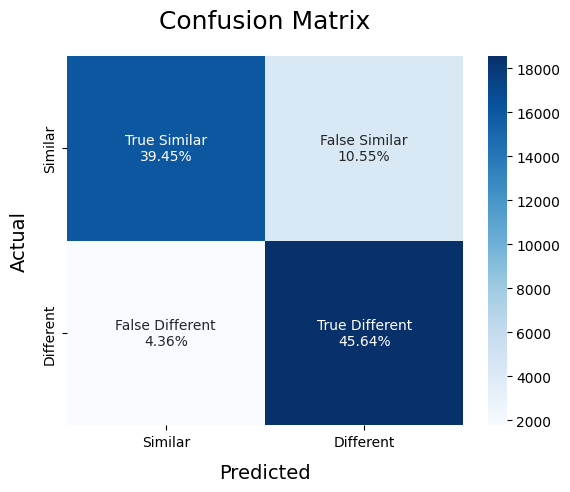

In [259]:
import seaborn as sns

def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)
    
    # Compute and print the accuracy
    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    plt.savefig("models/celeb/Histogram Train.jpg", dpi = 200)


threshold = 1
pos_list = np.where(np.array(ap_test)<=threshold, 0, 1)
neg_list = np.where(np.array(an_test)<=threshold, 0, 1)

ModelMetrics(pos_list, neg_list)

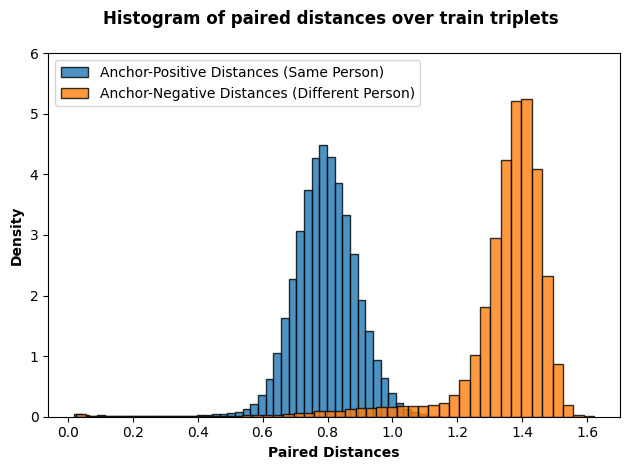

In [268]:
import matplotlib.pyplot as plt

def dual_hist(distances, labels, title, ylim):
    distances = np.array(distances)
    labels = np.array(labels)

    same = np.where(labels == 1)
    different = np.where(labels == 0)

    dist_same = distances[same]
    dist_different = distances[different]
    
    bins = 50

    plt.hist(dist_same, bins, alpha = 0.8, edgecolor='black', label='Anchor-Positive Distances (Same Person)', density = True)
    plt.hist(dist_different, bins, alpha = 0.8, edgecolor='black',label='Anchor-Negative Distances (Different Person)', density = True)

    plt.legend(loc='upper left')
    plt.title(title, fontweight="bold")
    plt.xlabel("Paired Distances", fontweight = "bold")
    plt.ylabel("Density", fontweight = "bold")
    plt.ylim(ylim)
    plt.tight_layout()
    plt.savefig("models/celeb/Histogram Train.jpg", dpi = 200)

n = len(ap_train)
distances = np.sqrt(ap_train + an_train)
labels = [1]*n + [0]*n
dual_hist(distances, labels, title = "Histogram of paired distances over train triplets \n", ylim = [0, 6])


## Error Analysis
### Error measures

In [240]:
n = len(all_ap)
distances_train = np.array(all_ap + all_an).reshape(-1, 1)
distances_train = np.sqrt(distances_train)
y_train = np.array([0]*n + [1]*n)
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [245]:
n = len(ap_test)
distances_test = np.array(ap_test + an_test).reshape(-1, 1)
distances_test = np.sqrt(distances_test)
y_test = np.array([0]*n + [1]*n)
y_test

array([0, 0, 0, ..., 1, 1, 1])

In [167]:
import numpy as np

def recall(ytrue, yhat):
    ytrue = np.reshape(ytrue,(len(ytrue), 1))
    yhat = np.reshape(yhat,(len(yhat), 1))
    z = yhat + ytrue
    TP = np.sum(z == 2)  # TP
    TP_FN = np.sum(ytrue == 1) # TP + FN
    recall = TP/TP_FN
    return recall

def precision(ytrue, yhat):
    ytrue = np.reshape(ytrue,(len(ytrue), 1))
    yhat = np.reshape(yhat,(len(yhat), 1))
    z = yhat + ytrue
    TP = np.sum(z == 2)  # TP
    TP_FN = np.sum(yhat == 1) # TP + FP
    precision = TP/TP_FN
    return precision

def specificity(ytrue, yhat):
    ytrue = np.reshape(ytrue,(len(ytrue), 1))
    yhat = np.reshape(yhat,(len(yhat), 1))
    z = yhat + ytrue
    TN = np.sum(z == 0) # TN
    FP_TN = np.sum(ytrue == 0) # FP + TN
    return(TN/FP_TN)

def accuracy(ytrue, yhat):
    ytrue = np.reshape(ytrue,(len(ytrue), 1))
    yhat = np.reshape(yhat,(len(yhat), 1))
    z = yhat + ytrue
    TP = np.sum(z == 2)  # TP
    TN = np.sum(z == 0) # TN
    return((TP+TN)/len(z))

def generate_hard_label(distances, thresh):

    hard_label = []
    for dis in distances:
        if dis <= thresh:
            hard_label.append(0)
        else:
            hard_label.append(1)
    
    return hard_label

def f1(ytrue, yhat):
    p = precision(ytrue, yhat)
    r = recall(ytrue, yhat)
    f1 = (2*(p*r))/(p+r)
    return f1

## Error analysis by explicit face matching strictness threshold

### Find best threshold based on training data

In [239]:
distances_train = np.sqrt(all_ap + all_an)

acc = []

thresh = np.arange(0.4, 1.8, 0.01)
for threshold in thresh:
    pred_hard_train = np.where(distances_train<=threshold, 0, 1)
    acc.append(accuracy(y_train, pred_hard_train))
    
ind = np.argmax(acc)
print("Best threshold is:", round(thresh[ind], 2), "and maximum accuracy is:", max(acc), "under training triplets.")
# thresh

Best threshold is: 1.03 and maximum accuracy is: 0.9713059787506025 under training triplets.


In [244]:
threshold = 1.03

pred_train = np.where(distances_train<=threshold, 0, 1)

acc = accuracy(y_train, pred_train)
print("Accuracy:", acc)

r = recall(y_train, pred_train)
print("Recall: " + str(r))

s = specificity(y_train, pred_train)
print("Specificity: " + str(s))

Accuracy: 0.9713059787506025
Recall: 0.9498313040927094
Specificity: 0.9927806534084955


### Apply best threshold over test triplets and find accuracy measures

In [246]:
threshold = 1.03

pred_test = np.where(distances_test<=threshold, 0, 1)

acc = accuracy(y_test, pred_test)
print("Accuracy:", acc)

r = recall(y_test, pred_test)
print("Recall: " + str(r))

s = specificity(y_test, pred_test)
print("Specificity: " + str(s))

Accuracy: 0.8568234311268367
Recall: 0.9003390830016217
Specificity: 0.8133077792520517


## Error analysis by fitting logistic regression based classifier

### Fit logistic regression over train triplets

In [247]:
from sklearn import linear_model
lr = linear_model.LogisticRegression()
lr.fit(distances_train,y_train)

array([0, 1])

In [249]:
pred_train = lr.predict(distances_train)

acc = accuracy(y_train, pred_train)
print("Accuracy:", acc)

r = recall(y_train, pred_train)
print("Recall: " + str(r))

s = specificity(y_train, pred_train)
print("Specificity: " + str(s))

Accuracy: 0.9712640667239464
Recall: 0.9490664096062366
Specificity: 0.9934617238416563


In [183]:
threshold = 1
pred_hard_test = generate_hard_label(ap_test + an_test, thresh = threshold)
# pred_hard_test

In [250]:
pred_test = lr.predict(distances_test)

r = recall(y_test, pred_test)
print("Recall: " + str(r))

s = specificity(y_test, pred_test)
print("Specificity: " + str(s))

acc = accuracy(y_test, pred_test)
print("Accuracy:", acc)

Recall: 0.8984716693695022
Specificity: 0.8170426065162907
Accuracy: 0.8577571379428964


In [382]:
def distance(img1, img2):
    enc1 = encoder.predict(img1)
    enc2 = encoder.predict(img2)
    d = np.linalg.norm(np.subtract(enc1, enc2))
    return d

print(distance(img1, img2), distance(img1, img3))
print(distance(img1, img2), distance(img1, img5))
print(distance(img5, img6), distance(img5, img3))
print(distance(img5, img6), distance(img5, img1))

0.42677668 1.1931895
0.42677668 1.1713488
1.0660149 1.1720333
1.0660149 1.1713488


### Classify images

In [277]:
# Load model
encoder = tf.keras.models.load_model("models/celeb/encoder/face_model.h5", compile = False)

In [301]:
def classify_images(face_list1, face_list2, threshold=1, method = "threshold"):
    # Getting the encodings for the passed faces
    
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)
    
#     distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    distance = np.linalg.norm((tensor1-tensor2), axis = -1)
    if method == "threshold":
        prediction = np.where(distance<=threshold, 0, 1)
        
    if method == "logistic":
        prediction = lr.predict(distance.reshape(-1, 1))
        
    return prediction

array([1, 1, 1, 1, 0, 1, 0, 0])

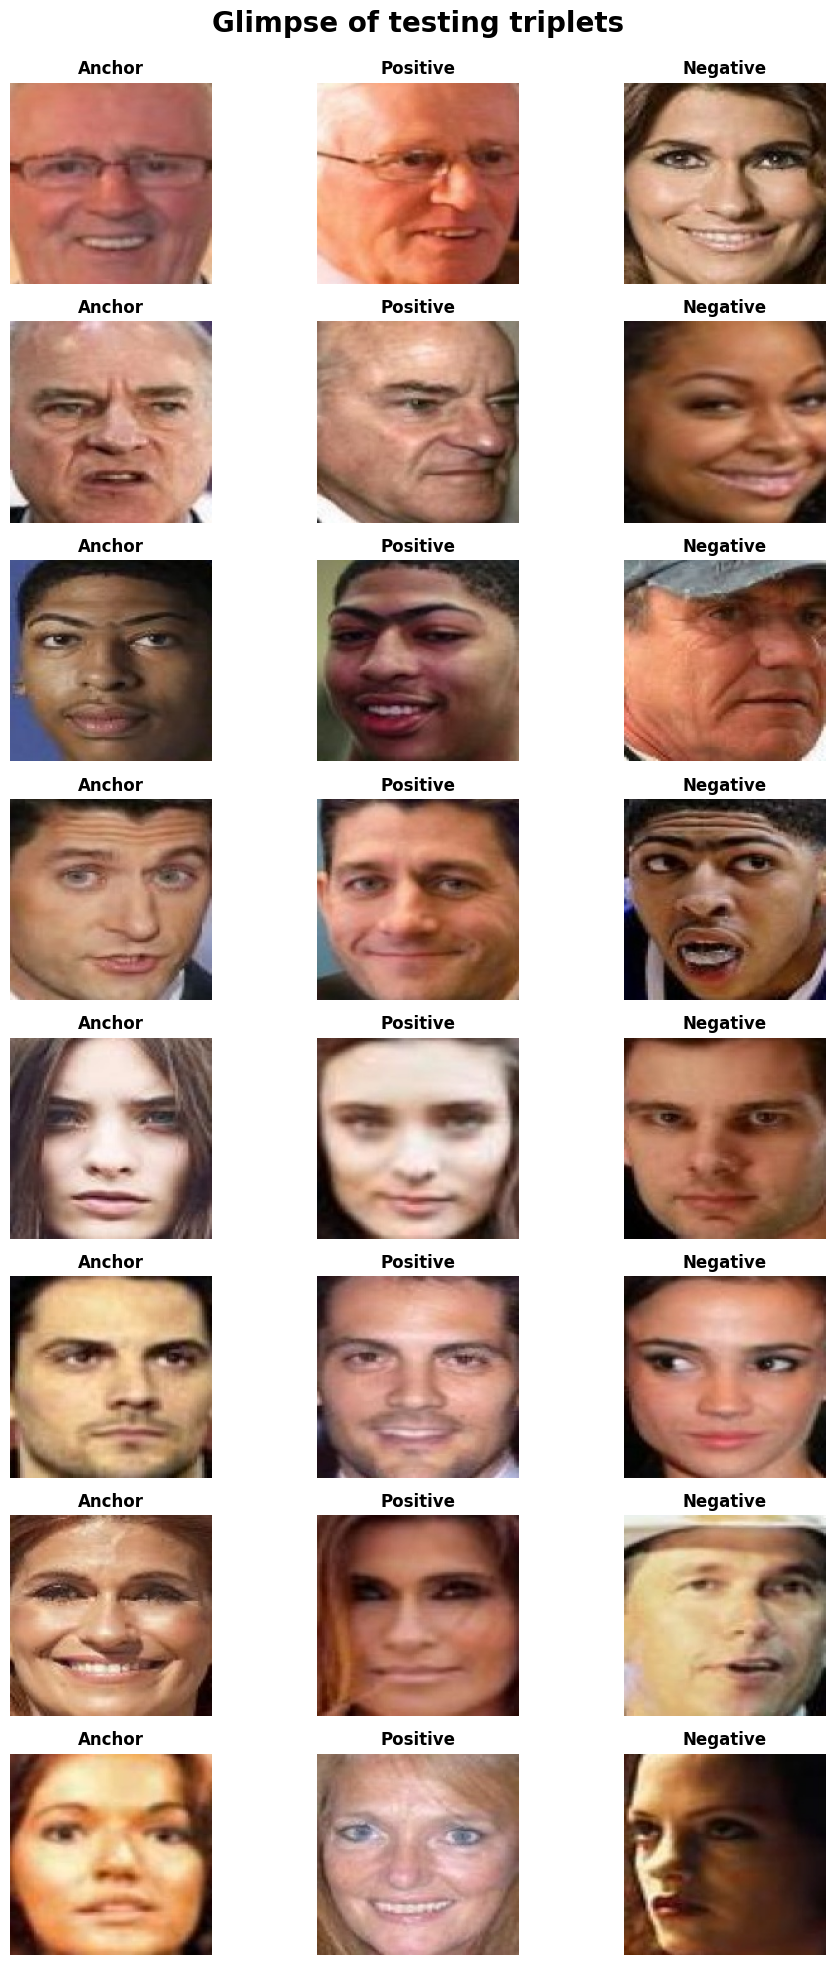

In [309]:
num_plots = 8

fig, axes = plt.subplots(num_plots, 3, figsize=(10, 20))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# fig = plt.figure()
fig.suptitle("Glimpse of testing triplets\n", fontsize=20, fontweight = "bold")

skip = 40; i = 0 # 10, 55, 90
for x in get_batch(test_directory, test_triplet, batch_size=num_plots, preprocess=False):
    if i>=skip:
        a,p,n = x
        for i in range(num_plots):
            axes[i, 0].imshow(a[i]); axes[i, 0].axis("off"); axes[i, 0].set_title("Anchor", fontsize=12, fontweight="bold")
            axes[i, 1].imshow(p[i]); axes[i, 1].axis("off"); axes[i, 1].set_title("Positive", fontsize=12, fontweight="bold")
            axes[i, 2].imshow(n[i]); axes[i, 2].axis("off"); axes[i, 2].set_title("Negative", fontsize=12, fontweight="bold")
            i+=1
        break
    i+=1

plt.axis("off")
plt.tight_layout()
# plt.savefig("models/celeb/Testing triplets.jpg", dpi = 50)

### Classify by optimal threshold t = 1.03

In [306]:
print("0 means same person, 1 means different person")
print("Anchor-positive predicted labels: ", classify_images(a, p, threshold = 1.03, method = "threshold"))
print("Anchor-negative predicted labels: ", classify_images(a, n, threshold = 1.03, method = "threshold"))

0 means same person, 1 means different person
Anchor-positive predicted labels:  [0 0 0 1 0 0 0 0]
Anchor-positive predicted labels:  [1 1 1 1 0 1 0 0]


### Classify by fitted logistic regression


In [307]:
print("0 means same person, 1 means different person")
print("Anchor-positive predicted labels: ",classify_images(a, p, method = "logistic"))
print("Anchor-negative predicted labels: ",classify_images(a, n, method = "logistic"))

0 means same person, 1 means different person
Anchor-positive predicted labels:  [0 0 0 1 0 0 0 0]
Anchor-negative predicted labels:  [1 1 1 1 0 1 0 0]


### Inference time of our model

In [308]:
import time

iterate = 100

t1 = time.time()
for i in range(iterate):
    enc = encoder.predict(a)
t = time.time() - t1

print("Time taken =", (t/iterate)*1000, "milli seconds.")

Time taken = 89.21812534332275 milli seconds.
